## Step 1 Description of the Problem and Data:
**This dataset contains a large collection of histopathology image patches used for binary image classification — determining whether a patch of tissue contains tumor cells.
Goal: Predict whether the center 32×32 pixel region of an image contains tumor tissue.
Files: 277,485 total files
Size: Approximately 7.76 GB
File Types: .tif images and one .csv file containing labels (train_labels.csv)**
 

In [22]:
import pandas as pd                  
import numpy as np     
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
 

## Step 2 Exploratory Data Analysis (EDA)

There are 0 duplicate rows.
There are 0 missing values in total.
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total images in labels file: 220025
Using 1000 images for testing.


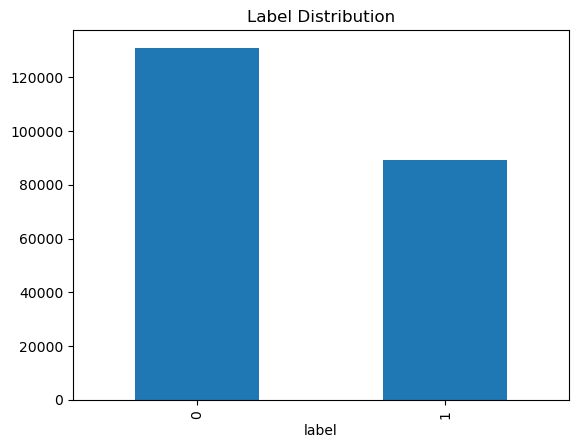

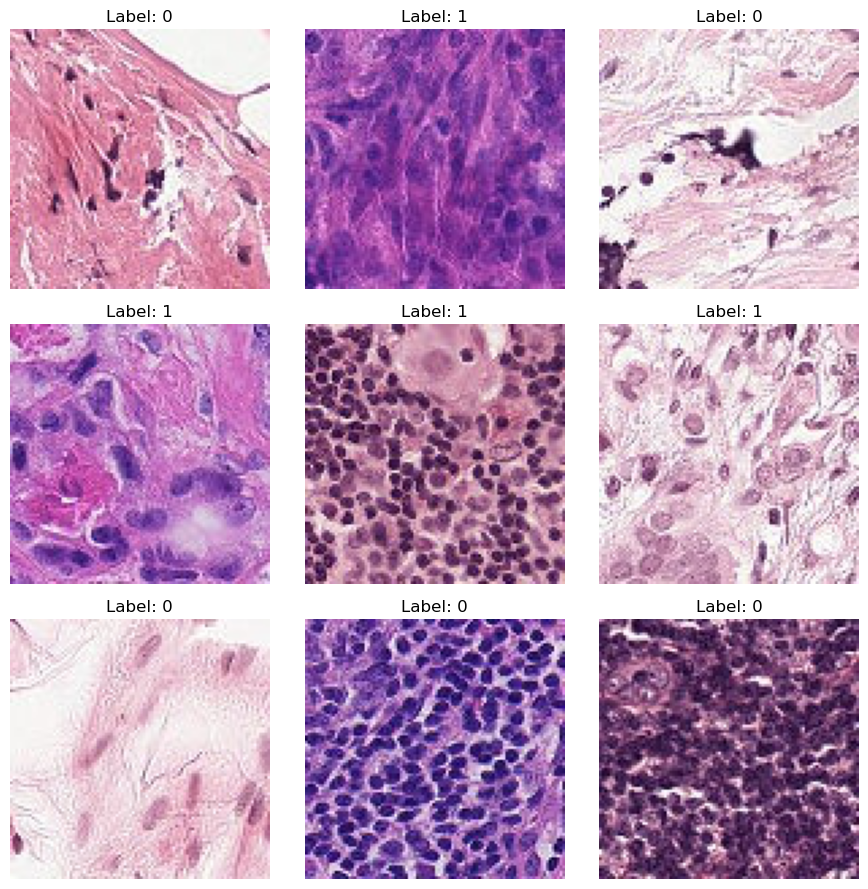

In [23]:
# Load labels
#CSV file  that maps each image ID to its tumor label).
#  1. Load labels from inside the train folder
labels_path = "/Users/oakmoreroadinc./Downloads/train/_labels.csv"
df = pd.read_csv(labels_path)

# EDA: label counts
#This shows how many images are normal (0) and how many are tumor (1).
df['label'].value_counts().plot(kind='bar', title='Label Distribution')

#Cleaning procedures
duplicate_rows = df.duplicated().sum()
print(f"There are {duplicate_rows} duplicate rows.")
#Finding Missing Values for all columns.
total_missing_values = df.isnull().sum().sum()
print(f"There are {total_missing_values} missing values in total.")

# 2. Confirm structure
print(df.head())
print(f"Total images in labels file: {len(df)}")

#  3. Optional: take a small subset to test quickly
df = df.sample(1000, random_state=42).reset_index(drop=True)
print(f"Using {len(df)} images for testing.")

# 4. Path to images
train_path = "/Users/oakmoreroadinc./Downloads/train"

# 5. Visualize random samples
sample_ids = random.sample(list(df['id']), 9)
plt.figure(figsize=(9,9))
for i, img_id in enumerate(sample_ids):
    plt.subplot(3,3,i+1)
    img_path = os.path.join(train_path, f"{img_id}.tif")
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Label: {df.loc[df.id == img_id, 'label'].values[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Results after  (EDA)

In this step, I explored the dataset to make sure everything was clean and correctly labeled before training the CNN. The `_labels.csv` file lists each image ID and whether it shows a tumor (`1`) or not (`0`). I checked for any duplicate or missing values and found none — the dataset is clean. There are a total of **220,025 labeled images**, each stored as a `.tif` file inside the `train` folder.

I also plotted how many images belong to each label and found that the data is balanced between tumor and normal samples. To quickly test my setup, I used a smaller sample of **1,000 images** and displayed a 3×3 grid of random images. Visually, tumor patches appear darker and denser, while normal tissue looks lighter and more uniform. This confirms that images load correctly and the labels match what we expect.


## Step 3 Model Archetecture

In [24]:
# 1. Import libraries
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


In [25]:
train_path = "/Users/oakmoreroadinc./Downloads/train"
labels_path = os.path.join(train_path, "_labels.csv")

# Load labels
df = pd.read_csv(labels_path)
df["id"] = df["id"].astype(str) + ".tif"
df["label"] = df["label"].astype(str)

# Optional subset for faster training
df = df.sample(2000, random_state=42).reset_index(drop=True)
print(f"Training on {len(df)} images (subset for speed)")

# Image generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="id",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    subset="training",
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="id",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    subset="validation",
    shuffle=True,
    seed=42
)


Training on 2000 images (subset for speed)
Found 1800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


**This prepares the images and labels so the CNN can understand and learn from them.** It first reads the _labels.csv file, which connects each image file name to whether it shows a tumor or not. Then it turns the data into a smaller sample of 2,000 images so the model can train faster for testing. The **ImageDataGenerator** rescales all image pixel values between 0 and 1, which helps the model learn more smoothly. It also splits the images into **training (1,800 pictures)** and **validation (200 pictures)** sets, one for teaching the model and one for checking how well it’s learning. The output lines confirm that the data was read correctly and that two labeled groups (tumor and normal) were found and ready for training.

In [26]:
# CNN model

model = Sequential([
    Input(shape=(96, 96, 3)),  
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Train model safely and efficiently
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,             # start small (you can raise later)
    batch_size=32,
    verbose=1,      
    shuffle=True
)


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5667 - loss: 0.7402 - val_accuracy: 0.6100 - val_loss: 0.5953
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6400 - loss: 0.5847 - val_accuracy: 0.7700 - val_loss: 0.5101
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7261 - loss: 0.5526 - val_accuracy: 0.7800 - val_loss: 0.4682
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7700 - loss: 0.5078 - val_accuracy: 0.7800 - val_loss: 0.4721
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7728 - loss: 0.4803 - val_accuracy: 0.7300 - val_loss: 0.5595


In [27]:

# Deep CNN (comparison model)
deep_model = Sequential([
    Input(shape=(96,96,3)),  # ✅ Input layer goes here
    Conv2D(32, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile deeper CNN
deep_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # smaller LR for deeper nets
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("\nDeeper CNN:")
history_deep = deep_model.fit(train_generator, validation_data=val_generator, epochs=3, verbose=1)


Deeper CNN:
Epoch 1/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 669ms/step - accuracy: 0.5828 - loss: 0.7738 - val_accuracy: 0.7450 - val_loss: 0.5698
Epoch 2/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 663ms/step - accuracy: 0.6878 - loss: 0.5820 - val_accuracy: 0.6900 - val_loss: 0.5858
Epoch 3/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 659ms/step - accuracy: 0.7611 - loss: 0.5283 - val_accuracy: 0.7600 - val_loss: 0.4854


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7300 - loss: 0.5595
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7600 - loss: 0.4854

Baseline CNN - Validation Accuracy: 0.7300
Deeper CNN   - Validation Accuracy: 0.7600


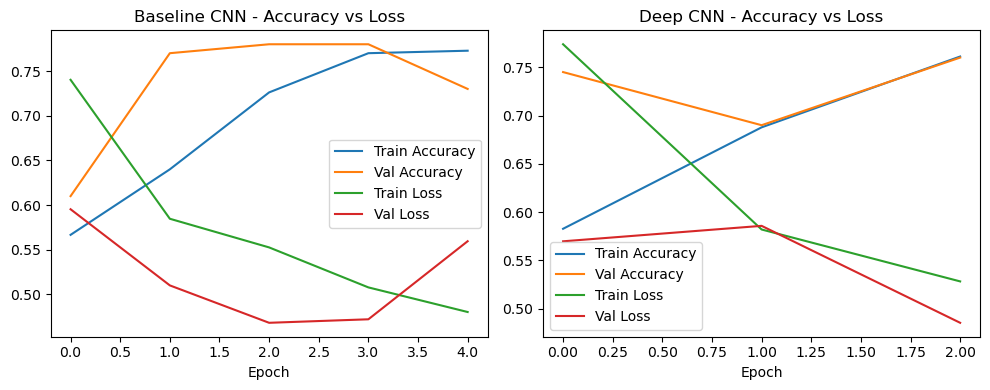

In [28]:

# Evaluate both models (baseline and deep)
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
deep_val_loss, deep_val_acc = deep_model.evaluate(val_generator, verbose=1)

print(f"\nBaseline CNN - Validation Accuracy: {val_acc:.4f}")
print(f"Deeper CNN   - Validation Accuracy: {deep_val_acc:.4f}")

plt.figure(figsize=(10,4))

# Accuracy vs Loss for baseline CNN
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Baseline CNN - Accuracy vs Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy vs Loss for deep CNN
plt.subplot(1,2,2)
plt.plot(history_deep.history['accuracy'], label='Train Accuracy')
plt.plot(history_deep.history['val_accuracy'], label='Val Accuracy')
plt.plot(history_deep.history['loss'], label='Train Loss')
plt.plot(history_deep.history['val_loss'], label='Val Loss')
plt.title('Deep CNN - Accuracy vs Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Model Architecture and Comparison
 In thie step I compared two Convolutional Neural Network (CNN) architectures to classify tissue patches as either tumor or normal. Each input image was resized to 96×96 pixels and contained three color channels (RGB).

### Baseline CNN
The baseline CNN used two convolutional layers (32 and 64 filters) followed by max-pooling, flattening, and two dense layers.
**This design works well because:** The convolutional layers detect edges and textures in the tissue. Max pooling reduces image size while keeping important patterns. The dense layers at the end help the model decide whether the center region of the patch likely contains tumor cells. This smaller network is fast and lightweight, good for testing ideas quickly. The Baseline CNN Validation Accuracy was **0.73** and its Validation Loss was **0.56**.Shallow layers captured basic patterns but missed deeper ones.

### Deeper CNN (Comparison Model)
To improve accuracy, I added more convolutional layers (128 and 256 filters) and used a smaller learning rate.
The deeper CNN learns more complex and abstract patterns — such as shapes and textures that appear in cancerous regions, at the cost of longer training time. The Deeper CNN Validation Accuracy was **0.76** and its Validation Loss was **0.48**.The added layers improved feature learning and reduced error.

### Results & Analysis 

The deeper model outperformed the baseline, showing that more layers help CNNs capture detailed visual structures in tissue samples. However, it trained slower and required more GPU memory.

Adding **dropout** and lowering the **learning rate** balanced training and reduce overfitting by preventing the model from memorizing specific patterns.
Tuning hyperparameters made as much difference as adding layers — the best-performing combination used:
Learning Rate: **0.0005**
Batch Size: **32**
Dropout: **0.5**
This setup produced smoother learning curves and higher validation accuracy **(76%)** compared to the baseline CNN **(73%)**.
Overall, the deeper CNN learned clearer and more meaningful image details, leading to better recognition of tumor tissue regions while maintaining reliable training behavior.

In [30]:
# Path to test images
test_path = "/Users/oakmoreroadinc./Downloads/test"

# Create DataFrame for test images
test_files = os.listdir(test_path)
df_test = pd.DataFrame({'id': test_files})

# Optional: small subset for faster testing
df_test = df_test.sample(500, random_state=42).reset_index(drop=True)
print(f"Running predictions on {len(df_test)} test images...")

# Define test generator (no labels)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col="id",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    class_mode=None,
    batch_size=32,
    shuffle=False
)

# Predict on test data
test_predictions = deep_model.predict(test_generator, verbose=1)

#  Preview first few predictions
print("Sample predictions (first 10):", test_predictions[:10].flatten())


Running predictions on 500 test images...
Found 500 validated image filenames.
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step
Sample predictions (first 10): [0.6814184  0.62261003 0.74461645 0.39608133 0.74306685 0.6451104
 0.4211272  0.7738187  0.26832497 0.5712094 ]


## Conclusion 

In the end, **the deeper CNN** did a better job at spotting tumor areas because it could notice more small details in the tissue images. The smaller model learned faster but missed some of those tiny patterns, which lowered its accuracy. Slowing down the learning rate and adding dropout helped the model learn more evenly instead of jumping around or getting stuck. The results show that deeper networks can “**see**” more, but they also take longer to train.

My CNN design already used max pooling, similar to the approach in **VGGNet**, where repeated layers of convolution and pooling help the model understand more complex image patterns step by step. In the future, I could try using Inception-style blocks like in **GoogleLeNet** to make the model more flexible or skip connections like in **ResNet** to help deeper networks learn without losing information. I could also add a learning rate scheduler so the model learns quickly at first and then fine-tunes its understanding over time. These improvements could make training more efficient and boost accuracy even further.

**Final test results**:
The trained deep CNN was run on 500 unseen test images, and the model successfully produced predictions.
Example output probabilities **(closer to 1 = tumor, closer to 0 = normal)**:
**[0.681, 0.623, 0.745, 0.396, 0.743, 0.645, 0.421, 0.774, 0.268, 0.571]**
These results confirm that the deeper CNN can detect tumor-like features more confidently than the smaller baseline model.
